In [1]:
from astropy import units as u
from astropy import constants as ac
import numpy as np
import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename 
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats
import astrobase
import astrobase.astrokep as kep
import astrobase.astrotess as tess
import astrobase.periodbase as abpb
import phoebe
import datetime as dt

[I 200824 19:44:32 backend:193] Loading KWallet
[I 200824 19:44:32 backend:193] Loading SecretService
[I 200824 19:44:32 backend:193] Loading Windows
[I 200824 19:44:32 backend:193] Loading chainer
[I 200824 19:44:32 backend:193] Loading macOS
[I 200824 19:44:41 __init__:84] An Astropy implementation of BLS is available because Astropy >= 3.1.
[I 200824 19:44:41 __init__:86] If you want to use it as the default periodbase BLS runner, call the periodbase.use_astropy_bls() function.
[I 200824 19:44:45 passbands:3076] initializing passband (headers only) at /usr/local/lib/python3.8/dist-packages/phoebe/atmospheres/tables/passbands/johnson_v.fits
[I 200824 19:44:45 passbands:3076] initializing passband (headers only) at /usr/local/lib/python3.8/dist-packages/phoebe/atmospheres/tables/passbands/bolometric.fits


In [2]:
%matplotlib inline

# Getting the data

In [3]:
#importing the LC fits file
filename = get_pkg_data_filename('V453_tess-0150-s_lc.fits')

#reading the LC fits file
ts = TimeSeries.read(filename, format='tess.fits')


time = ts.time.jd - ts.time.jd[0]
flux = ts['pdcsap_flux']
flux_err = ts['pdcsap_flux_err']

sel_nan = np.isnan(ts['pdcsap_flux'])
time = time[~sel_nan]
flux = flux[~sel_nan]
flux_err = flux_err[~sel_nan]

mean, median, stddev = sigma_clipped_stats(flux)  
flux_norm = flux / median

/home/amazing_bhavesh/.local/lib/python3.8/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))


In [4]:
lcdict = tess.read_tess_fitslc('V453_tess-0150-s_lc.fits')
lc_mag = tess.normalized_flux_to_mag(lcdict)

ab_sel_nan = np.isnan(lc_mag['sap']['sap_flux'])

ab_sap_flux = (lc_mag['sap']['sap_flux'])[~ab_sel_nan]
ab_sap_flux_err = (lc_mag['sap']['sap_flux_err'])[~ab_sel_nan]
ab_pdc_flux = (lc_mag['pdc']['pdcsap_flux'])[~ab_sel_nan]
ab_pdc_flux_err = (lc_mag['pdc']['pdcsap_flux_err'])[~ab_sel_nan]
ab_sap_mag = (lc_mag['sap']['sap_mag'])[~ab_sel_nan]
ab_sap_mag_err = (lc_mag['sap']['sap_mag_err'])[~ab_sel_nan]
ab_pdc_mag = (lc_mag['pdc']['pdcsap_mag'])[~ab_sel_nan]
ab_pdc_mag_err = (lc_mag['pdc']['pdcsap_mag_err'])[~ab_sel_nan]

ab_time = (lc_mag['time']-lc_mag['time'][0])[~ab_sel_nan]

ab_mean, ab_median, ab_stddev = sigma_clipped_stats(ab_pdc_flux)  
ab_flux_norm = ab_sap_flux / ab_median

/home/amazing_bhavesh/.local/lib/python3.8/site-packages/astrobase/astrotess.py:104: RuntimeWarning: invalid value encountered in log10
  - 2.5*np.log10(1.0 - lcdict[k1][k2])
[W 200824 19:44:48 logger:204] Input data contains invalid values (NaNs or infs), which were automatically clipped.


In [5]:
#function to convert jd to days w.r.t to the first date
def timedif(times):    
    data = [dt.datetime.strptime(t,"%Y-%m-%dT%H:%M:%S.%f") for t in times]
    diff = []
    for i in range(len(data)):
        delt = data[i]-data[0]
        diff.append(delt.days+((delt.seconds + delt.microseconds*1e-6)*1.15741e-5)) 
    return diff*u.day

sel_nan = np.isnan(ts['pdcsap_flux'])
t = timedif(ts.time.value[~sel_nan]) #time array in days

In [6]:
t1 = np.where(t.value<7.5)
t_red = t[t1]
f_red = flux[t1]
ferr_red = flux_err[t1]
fnorm_red = flux_norm[t1]
fnerr_red = ferr_red / sigma_clipped_stats(ferr_red)[1]

(-0.374866578270455, 7.8721981436795545)

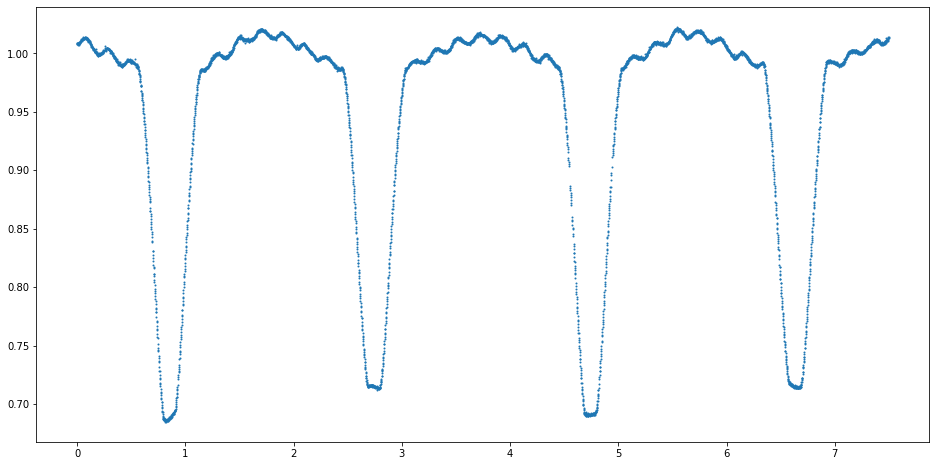

In [7]:
plt.figure(figsize=(16,8))
plt.scatter(t_red,flux_norm[t1],s=1)
plt.xlim()

In [8]:
plt.figure(figsize=(16,8))
plt.scatter(t_sap.value, (f_sap.value*ac.e.value), s=1)
plt.xlim()

NameError: name 't_sap' is not defined

<Figure size 1152x576 with 0 Axes>

# Period finding and Phase calculation

In [9]:
sel_nan_sap = np.isnan(ts['sap_flux'])
t_sap = timedif(ts.time.value[~sel_nan_sap])
f_sap = ts['sap_flux'][~sel_nan_sap]
ferr_sap = ts['sap_flux_err'][~sel_nan_sap]

fnorm_sap = f_sap / sigma_clipped_stats(f_sap)[1]
fnerr_sap = ferr_sap / sigma_clipped_stats(ferr_sap)[1]

In [10]:
lsp = abpb.kbls.bls_serial_pfind(t_sap.value, fnorm_sap.value, fnerr_sap.value, magsarefluxes=True)

[I 200824 20:04:09 kbls:382] min P: 0.1, max P: 100.0, nfreq: 107294, minfreq: 0.01, maxfreq: 10.0
[I 200824 20:04:09 kbls:385] autofreq = True: using AUTOMATIC values for freq stepsize: 9.310919979396945e-05, nphasebins: 200, min transit duration: 0.01, max transit duration: 0.4
[W 200824 20:04:09 kbls:419] the requested max P = 100.000 is larger than the time base of the observations = 26.850,  will make minfreq = 2 x 1/timebase
[W 200824 20:04:09 kbls:424] new minfreq: 0.07448735983517556, maxfreq: 10.0
[I 200824 20:04:20 kbls:553] Getting stats for best period: 1.943554
[I 200824 20:04:20 kbls:382] min P: 1.7491982518568407, max P: 2.1379089744916944, nfreq: 1117, minfreq: 0.4677467618740682, maxfreq: 0.5716904867349724
[I 200824 20:04:20 kbls:385] autofreq = True: using AUTOMATIC values for freq stepsize: 9.310919979396945e-05, nphasebins: 200, min transit duration: 0.01, max transit duration: 0.4
/home/amazing_bhavesh/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3

[I 200824 20:04:23 nonphysical:436] SG filter applied. chisq = 0.12394, reduced chisq = -99.00000
[W 200824 20:04:23 kbls:1143] minimum epoch is actually an array:
array([12.67795387])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[I 200824 20:04:24 transits:452] final fit done. chisq = 16.47453, reduced chisq = 0.00109
[I 200824 20:04:24 kbls:1226] refit best period: 11.669569, refit center of transit: 12.67274
[I 200824 20:04:24 kbls:1230] npoints in transit: 258
[I 200824 20:04:24 kbls:1232] transit depth (delta): 0.15352, frac transit length (q): 0.022,  SNR: 77.479


In [11]:
lsp['stats'][1]

{'period': 3.88918257520725,
 'epoch': 10.368386094193411,
 'snr': 125.54441300973404,
 'transitdepth': 0.1476098349811146,
 'transitduration': 0.06868461130139779,
 'ingressduration': 0.03422006322558085,
 'npoints_in_transit': 632,
 'fitparams': array([ 3.88918258, 10.36838609,  0.14760983,  0.06868461,  0.03422006]),
 'fiterrs': array([5.36610467e-04, 2.66380426e+05, 3.89392304e+05, 1.36985303e+05,
        9.02720003e+04]),
 'fit_status': 'ok',
 'nphasebins': 200,
 'transingressbin': 130,
 'transegressbin': 153,
 'blsmodel': array([0.9989078 , 0.9989078 , 0.9989078 , ..., 0.85684742, 0.85530698,
        0.85405745]),
 'subtractedmags': array([-0.15071958, -0.14907575, -0.15045577, ..., -0.00452514,
        -0.00546562, -0.00522204]),
 'phasedmags': array([0.8481882 , 0.84983206, 0.84845203, ..., 0.8523223 , 0.84984136,
        0.8488354 ], dtype=float32),
 'phases': array([0.07929617, 0.07935787, 0.07959029, ..., 0.99859124, 0.99894836,
        0.99923803]),
 'fitinfo': {'fittype': 

In [12]:
period = lsp['stats'][1]['period']
period

3.88918257520725

In [13]:
phase = np.remainder(time+period/2, period)/period
phase_red = np.remainder((t_red.value)+period/2, period)/period
#phase = lsp['stats'][1]['fitinfo']['magseries']['phase']
#mags = lsp['stats'][1]['fitinfo']['magseries']['mags']

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(phase_red, f_red, s=1, color='k')
plt.xlabel("Phase")
plt.ylabel("PDCSAP Flux [e/s]")

In [ ]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.scatter(phase_red, fnorm_red-(np.max(flux_norm)-1), s=1, color='k')
plt.xlabel("Phase")
plt.ylabel("Normalised Flux")

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(phase, flux, s=1, color='k')
plt.xlabel("Phase")
plt.ylabel("PDCSAP Flux [e/s]")

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(phase, flux_norm, s=1, color='k')
plt.xlabel("Phase")
plt.ylabel("Normalised Flux")

# Analysis with Astrobase

In [14]:
period = lsp['stats'][1]['period']
epoch = lsp['stats'][1]['epoch']
tra_depth = lsp['stats'][1]['transitdepth']
tra_dur = lsp['stats'][1]['transitduration']
ingress_dur = lsp['stats'][1]['ingressduration']
epoch_jd = ts.time.jd[np.where((t_sap.value>=10.367) & (t_sap.value<=10.369))]
tra_dur_phase = np.remainder(tra_dur+period/2, period)/period
epoch_phase = np.remainder(epoch+period/2, period)/period

In [15]:
0.99
s_x = 0.20539 #phase
s_y = 0.71479
p_x = 0.72 #phase
p_y = 0.69101

pdepth = 0.99 - p_y
sdepth = 0.99 - s_y
psdepthratio = sdepth/pdepth
print(pdepth)
print(sdepth)
print(tra_depth)

0.29899
0.27520999999999995
0.1476098349811146


In [16]:
ebparams = [period,
            epoch_jd,
            pdepth,
            tra_dur_phase,
            psdepthratio,
            s_x]

In [17]:
import astrobase.lcfit as lf

In [18]:
lf.eclipses.gaussianeb_fit_magseries(t_sap.value, fnorm_sap.value, fnerr_sap.value, ebparams, plotfit='fit', magsarefluxes=True)

/home/amazing_bhavesh/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
[I 200824 20:04:28 eclipses:424] final fit done. chisq = 26.57335, reduced chisq = 0.00167


{'fittype': 'gaussianeb',
 'fitinfo': {'initialparams': [3.88918257520725,
   array([2458693.45306262]),
   0.29899,
   0.5176604234882796,
   0.9204655674102812,
   0.20539],
  'finalparams': array([3.88918313e+00, 2.45869395e+06, 2.00556436e-01, 3.52625079e-01,
         6.83238900e-02, 5.37603731e-03]),
  'finalparamerrs': array([1.21051590e-09, 7.23281345e-04, 2.69018534e-03, 3.85891387e-03,
         1.08241504e-02, 1.52024642e-02]),
  'fitmags': array([0.98429311, 0.98429203, 0.9842911 , ..., 0.79740065, 0.79740047,
         0.79740045]),
  'fitepoch': 2458693.9535159618},
 'fitchisq': 26.57335072857186,
 'fitredchisq': 0.0016682372232137523,
 'fitplotfile': 'fit',
 'magseries': {'phase': array([4.90447273e-05, 1.23170670e-04, 1.88273261e-04, ...,
         9.99896314e-01, 9.99956163e-01, 9.99973047e-01]),
  'times': array([18.4932526 , 14.60435775, 10.71542782, ..., 26.27102487,
          2.93615883, 22.38214016]),
  'mags': array([0.89400214, 0.8954673 , 0.9007259 , ..., 0.8930177

In [19]:
lf.nonphysical.savgol_fit_magseries(t_sap.value, fnorm_sap.value, fnerr_sap.value, period, windowlength=None, polydeg=6, sigclip=30.0, plotfit='fit2', magsarefluxes=True, verbose=True)

[I 200824 20:04:29 nonphysical:409] applying Savitzky-Golay filter with window length 61 and polynomial degree 6 to mag series with 18298 observations, using period 3.889183, folded at 0.000000
[I 200824 20:04:29 nonphysical:436] SG filter applied. chisq = 0.19183, reduced chisq = -99.00000


{'fittype': 'savgol',
 'fitinfo': {'windowlength': 61,
  'polydeg': 6,
  'fitmags': array([1.0111669, 1.0109601, 1.0104253, ..., 1.0105715, 1.0107793,
         1.010891 ], dtype=float32),
  'fitepoch': array([24.1863042])},
 'fitchisq': 0.19183306,
 'fitredchisq': -99.0,
 'fitplotfile': 'fit2',
 'magseries': {'times': array([ 0.        , 19.44603062, 15.55713774, ...,  7.77789133,
          3.88895031, 23.33491675]),
  'phase': array([0.00000000e+00, 3.02740032e-05, 1.04762429e-04, ...,
         9.99878169e-01, 9.99940280e-01, 9.99954051e-01]),
  'mags': array([1.0092404, 1.0057259, 1.0022568, ..., 1.0158197, 1.011934 ,
         1.0140674], dtype=float32),
  'errs': array([0.98758924, 1.0125964 , 0.9900541 , ..., 1.0806925 , 1.0072874 ,
         1.2784632 ], dtype=float32),
  'magsarefluxes': True}}

# Analysis with PHOEBE 

In [20]:
import phoebe
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=14, serif='STIXGeneral')
plt.rc('mathtext', fontset='stix')

logger = phoebe.logger('error')
phoebe.mpi_on()

b = phoebe.default_binary()

b.set_value('ecc',0.022)
b.set_value('per0',140.1) #deg
b.set_value('teff@primary',27900) #K
b.set_value('teff@secondary',26200) #K
b.set_value('sma@binary',35.56) #solRadius
b.set_value('incl@binary',89) #deg
b.set_value('q',0.773)
b.set_value('t0_supconj',10.37) #days
b.set_value('requiv@primary',8.5) #solRadius
b.set_value('vgamma',-18.16)  #km/s

b.set_value_all('atm@primary', 'phoenix')
b.set_value_all('atm@secondary', 'phoenix')
b.set_value_all('irrad_frac_refl_bol', 1.0)
b.set_value_all('gravb_bol', 1.0)
b.set_value_all('irrad_method', 'wilson')
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('ld_coeffs_bol', [0.2, 0.2])



lctimes = phoebe.linspace(0, 10, 501)
rvtimes = phoebe.linspace(0, 10, 101)
b.add_dataset('lc', compute_times=lctimes, overwrite=True)
b.add_dataset('rv', compute_times=rvtimes)

#computing values of model
b.add_compute('ellc', compute='fastcompute', overwrite=True)
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_coeffs', [0.2, 0.2])
print(b.run_checks())

In [21]:
from astropy.io import fits

In [22]:
fits.open(filename)[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                19337 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [23]:
e/s * e_charge = current -- analogous to voltage

SyntaxError: invalid syntax (<ipython-input-23-a0c7dfeabf54>, line 1)

In [24]:
f = fits.open(filename)
f.info()

Filename: V453_tess-0150-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    161   19337R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   


In [25]:
hdu = f[0]

In [26]:
hdu.header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-04-08'         / file creation date.                            
TSTART  =    1683.356394218073 / observation start time in BTJD                 
TSTOP   =    1710.207974143471 / observation stop time in BTJD                  
DATE-OBS= '2019-07-18T20:32:

In [45]:
10+(-0.25*(np.log((flux.value/5.21999979019165)/12500))) #12500 or 15000

array([9.489086, 9.489388, 9.489167, ..., 9.489533, 9.489525, 9.489541],
      dtype=float32)

In [33]:
T = f[0].header['TESSMAG']

In [36]:
mag = T - 2.5*np.log(flux/median) #normalised flux to magnitude
mag*u.mag



<Quantity [8.068913 , 8.071933 , 8.0697155, ..., 8.07338  , 8.073297 ,
           8.073458 ] mag>

In [43]:
- T + 2.5*np.log(mean.value)

20.57429886237549

In [39]:
20.60654144 - 2.5*np.log(mean.value)

-8.058357432375487

In [40]:
T

8.09060001

In [135]:
t1 = np.where(t.value<7.5)
t_red = t[t1]
f_red = flux[t1]
ferr_red = flux_err[t1]
fnorm_red = flux_norm[t1]
fnerr_red = ferr_red/np.mean(ferr_red) - 1
phase_red = np.remainder((t_red.value)+period/2, period)/period

In [136]:
m = 10-(0.25*(np.log(f_red.value/15000)))
F_0 = (4.03*(10**6))*u.erg/u.s/(u.cm**2)
F_si= F_0.to((u.W)/(u.m**2))
F = F_si*(10**((-0.4)*m))

In [172]:
merr = 10-(0.25*(np.log((f_red.value+ferr_red.value)/15000)))
Ferr_0 = (4.03*(10**6))*u.erg/u.s/(u.cm**2)
Ferr_si= F_0.to((u.W)/(u.m**2))
Ferr = F_si*(10**((-0.4)*merr))
F_err = Ferr-F

In [173]:
F

<Quantity [0.61864024, 0.61846817, 0.61859477, ..., 0.6191948 , 0.6192128 ,
           0.61932194] W / m2>

In [189]:
b = phoebe.default_binary()

b.set_value('latex_repr', component='binary', value='orb')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')
b.set_value('period@binary', period)

b.add_dataset('lc',
            compute_phases=phoebe.linspace(0,1,531),
            times=t_red[0::10],
            fluxes=F[0::10],
            sigmas=F_err[0::10],
            dataset='lc01', overwrite=True)


b.set_value_all('ld_mode', 'lookup')

[I 200825 01:27:08 bundle:5713] calling add_figure(kind='dataset.lc') since auto_add_figure@setting=True
[I 200825 01:27:08 bundle:6502] flipping constraint 'compute_phases@constraint' to solve for 'compute_times'


[W 200825 01:27:09 parameters:3974] assuming you meant 'ec' instead of 'edgecolors'
[W 200825 01:27:09 parameters:4035] fc and ec are not allowable for dataset=lc01 with kind=lc, ignoring ec=none
[I 200825 01:27:09 parameters:5423] calling autofig.plot(x=<data ((531,) unit=)>, s=0.01, legend=True, xlabel=phase, xqualifier=phases, linebreak=x-, y=<data ((531,) unit=W / m2)>, yerror=<data ((531,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=x, iqualifier=None, linestyle=none, label=lc01)
[I 200825 01:27:09 parameters:5553] calling autofig.draw(i=None, draw_sidebars=False, draw_title=False, tight_layout=False, save=False, show=True)


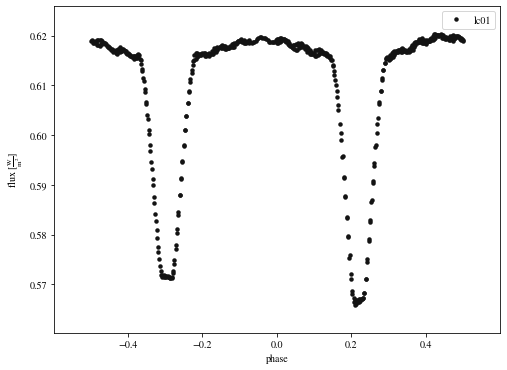

In [190]:
afig, mplfig = b.plot(x='phases',s=0.01,legend=True, edgecolors='none', show=True)

In [191]:
b.add_solver('estimator.lc_geometry', lc='lc01')
b.run_solver(kind='lc_geometry', solution='lc_geom_sol')
print(b.adopt_solution('lc_geom_sol', trial_run=True))
afig, mplfig = b.plot(solution='lc_geom_sol', show = True)

[I 200825 01:30:29 bundle:10532] adding lc_geometry 'lc_geometry01' solver to bundle
[W 200825 01:30:29 bundle:2766] 'lc' not a recognized kwarg
[I 200825 01:30:30 parameters:11812] current status: running, trying again in 5s
[I 200825 01:30:35 parameters:11812] current status: running, trying again in 5s
[I 200825 01:30:40 parameters:11812] current status: running, trying again in 5s
[I 200825 01:30:45 parameters:11812] current status: running, trying again in 5s
[I 200825 01:30:50 parameters:11812] current status: running, trying again in 5s
[I 200825 01:30:55 parameters:11812] current status: running, trying again in 5s
[I 200825 01:31:00 parameters:11812] current status: running, trying again in 5s
[I 200825 01:31:05 parameters:11812] current status: running, trying again in 5s
[I 200825 01:31:10 parameters:11812] current status: running, trying again in 5s
[I 200825 01:31:15 parameters:11812] current status: running, trying again in 5s
[I 200825 01:31:20 parameters:11812] current 

[I 200825 01:38:53 parameters:11812] current status: running, trying again in 5s
[I 200825 01:38:58 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:03 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:08 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:13 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:18 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:23 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:28 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:33 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:39 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:44 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:49 parameters:11812] current status: running, trying again in 5s
[I 200825 01:39:54 parameter

[I 200825 01:47:27 parameters:11812] current status: running, trying again in 5s
[I 200825 01:47:32 parameters:11812] current status: running, trying again in 5s
[I 200825 01:47:37 parameters:11812] current status: running, trying again in 5s
[I 200825 01:47:42 parameters:11812] current status: running, trying again in 5s
[I 200825 01:47:47 parameters:11812] current status: running, trying again in 5s
[I 200825 01:47:52 parameters:11812] current status: running, trying again in 5s
[I 200825 01:47:57 parameters:11812] current status: running, trying again in 5s
[I 200825 01:48:02 parameters:11812] current status: running, trying again in 5s
[I 200825 01:48:07 parameters:11812] current status: running, trying again in 5s
[I 200825 01:48:12 parameters:11812] current status: running, trying again in 5s
[I 200825 01:48:17 parameters:11812] current status: running, trying again in 5s
[I 200825 01:48:22 parameters:11812] current status: running, trying again in 5s
[I 200825 01:48:27 parameter

[I 200825 01:56:00 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:05 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:10 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:16 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:21 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:26 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:31 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:36 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:41 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:46 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:51 parameters:11812] current status: running, trying again in 5s
[I 200825 01:56:56 parameters:11812] current status: running, trying again in 5s
[I 200825 01:57:01 parameter

[I 200825 02:04:34 parameters:11812] current status: running, trying again in 5s
[I 200825 02:04:39 parameters:11812] current status: running, trying again in 5s
[I 200825 02:04:44 parameters:11812] current status: running, trying again in 5s
[I 200825 02:04:49 parameters:11812] current status: running, trying again in 5s
[I 200825 02:04:54 parameters:11812] current status: running, trying again in 5s
[I 200825 02:04:59 parameters:11812] current status: running, trying again in 5s
[I 200825 02:05:04 parameters:11812] current status: running, trying again in 5s
[I 200825 02:05:10 parameters:11812] current status: running, trying again in 5s
[I 200825 02:05:15 parameters:11812] current status: running, trying again in 5s
[I 200825 02:05:20 parameters:11812] current status: running, trying again in 5s
[I 200825 02:05:25 parameters:11812] current status: running, trying again in 5s
[I 200825 02:05:30 parameters:11812] current status: running, trying again in 5s
[I 200825 02:05:35 parameter

[I 200825 02:13:59 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:04 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:09 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:14 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:19 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:24 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:29 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:34 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:39 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:44 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:49 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:54 parameters:11812] current status: running, trying again in 5s
[I 200825 02:14:59 parameter

[I 200825 02:23:23 parameters:11812] current status: running, trying again in 5s
[I 200825 02:23:28 parameters:11812] current status: running, trying again in 5s
[I 200825 02:23:33 parameters:11812] current status: running, trying again in 5s
[I 200825 02:23:38 parameters:11812] current status: running, trying again in 5s
[I 200825 02:23:43 parameters:11812] current status: running, trying again in 5s
[I 200825 02:23:48 parameters:11812] current status: running, trying again in 5s
[I 200825 02:23:53 parameters:11812] current status: running, trying again in 5s
[I 200825 02:23:58 parameters:11812] current status: running, trying again in 5s
[I 200825 02:24:03 parameters:11812] current status: running, trying again in 5s
[I 200825 02:24:08 parameters:11812] current status: running, trying again in 5s
[I 200825 02:24:13 parameters:11812] current status: running, trying again in 5s
[I 200825 02:24:18 parameters:11812] current status: running, trying again in 5s
[I 200825 02:24:23 parameter

[I 200825 02:31:56 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:01 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:06 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:12 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:17 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:22 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:27 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:32 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:37 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:42 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:47 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:52 parameters:11812] current status: running, trying again in 5s
[I 200825 02:32:57 parameter

[I 200825 02:40:30 parameters:11812] current status: running, trying again in 5s
[I 200825 02:40:35 parameters:11812] current status: running, trying again in 5s
[I 200825 02:40:40 parameters:11812] current status: running, trying again in 5s
[I 200825 02:40:45 parameters:11812] current status: running, trying again in 5s
[I 200825 02:40:50 parameters:11812] current status: running, trying again in 5s
[I 200825 02:40:55 parameters:11812] current status: running, trying again in 5s
[I 200825 02:41:00 parameters:11812] current status: running, trying again in 5s
[I 200825 02:41:05 parameters:11812] current status: running, trying again in 5s
[I 200825 02:41:11 parameters:11812] current status: running, trying again in 5s
[I 200825 02:41:16 parameters:11812] current status: running, trying again in 5s
[I 200825 02:41:21 parameters:11812] current status: running, trying again in 5s
[I 200825 02:41:26 parameters:11812] current status: running, trying again in 5s
[I 200825 02:41:31 parameter

[I 200825 02:49:03 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:08 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:13 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:18 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:23 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:28 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:33 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:38 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:43 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:48 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:54 parameters:11812] current status: running, trying again in 5s
[I 200825 02:49:59 parameters:11812] current status: running, trying again in 5s
[I 200825 02:50:04 parameter

[I 200825 02:57:36 parameters:11812] current status: running, trying again in 5s
[I 200825 02:57:41 parameters:11812] current status: running, trying again in 5s
[I 200825 02:57:46 parameters:11812] current status: running, trying again in 5s
[I 200825 02:57:51 parameters:11812] current status: running, trying again in 5s
[I 200825 02:57:56 parameters:11812] current status: running, trying again in 5s
[I 200825 02:58:01 parameters:11812] current status: running, trying again in 5s
[I 200825 02:58:07 parameters:11812] current status: running, trying again in 5s
[I 200825 02:58:12 parameters:11812] current status: running, trying again in 5s
[I 200825 02:58:17 parameters:11812] current status: running, trying again in 5s
[I 200825 02:58:22 parameters:11812] current status: running, trying again in 5s
[I 200825 02:58:27 parameters:11812] current status: running, trying again in 5s
[I 200825 02:58:32 parameters:11812] current status: running, trying again in 5s
[I 200825 02:58:37 parameter

[I 200825 03:06:09 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:14 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:19 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:24 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:29 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:34 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:39 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:45 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:50 parameters:11812] current status: running, trying again in 5s
[I 200825 03:06:55 parameters:11812] current status: running, trying again in 5s
[I 200825 03:07:00 parameters:11812] current status: running, trying again in 5s
[I 200825 03:07:05 parameters:11812] current status: running, trying again in 5s
[I 200825 03:07:10 parameter

[I 200825 03:14:43 parameters:11812] current status: running, trying again in 5s
[I 200825 03:14:48 parameters:11812] current status: running, trying again in 5s
[I 200825 03:14:53 parameters:11812] current status: running, trying again in 5s
[I 200825 03:14:58 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:03 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:08 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:13 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:18 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:23 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:28 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:33 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:38 parameters:11812] current status: running, trying again in 5s
[I 200825 03:15:43 parameter

[I 200825 03:23:17 parameters:11812] current status: running, trying again in 5s
[I 200825 03:23:22 parameters:11812] current status: running, trying again in 5s
[I 200825 03:23:27 parameters:11812] current status: running, trying again in 5s
[I 200825 03:23:32 parameters:11812] current status: running, trying again in 5s
[I 200825 03:23:37 parameters:11812] current status: running, trying again in 5s
[I 200825 03:23:42 parameters:11812] current status: running, trying again in 5s
[I 200825 03:23:47 parameters:11812] current status: running, trying again in 5s
[I 200825 03:23:52 parameters:11812] current status: running, trying again in 5s
[I 200825 03:23:57 parameters:11812] current status: running, trying again in 5s
[I 200825 03:24:02 parameters:11812] current status: running, trying again in 5s
[I 200825 03:24:07 parameters:11812] current status: running, trying again in 5s
[I 200825 03:24:12 parameters:11812] current status: running, trying again in 5s
[I 200825 03:24:17 parameter

[I 200825 03:31:50 parameters:11812] current status: running, trying again in 5s
[I 200825 03:31:55 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:00 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:05 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:10 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:15 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:20 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:25 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:31 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:36 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:41 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:46 parameters:11812] current status: running, trying again in 5s
[I 200825 03:32:51 parameter

[I 200825 03:40:23 parameters:11812] current status: running, trying again in 5s
[I 200825 03:40:28 parameters:11812] current status: running, trying again in 5s
[I 200825 03:40:33 parameters:11812] current status: running, trying again in 5s
[I 200825 03:40:38 parameters:11812] current status: running, trying again in 5s
[I 200825 03:40:43 parameters:11812] current status: running, trying again in 5s
[I 200825 03:40:48 parameters:11812] current status: running, trying again in 5s
[I 200825 03:40:53 parameters:11812] current status: running, trying again in 5s
[I 200825 03:40:58 parameters:11812] current status: running, trying again in 5s
[I 200825 03:41:03 parameters:11812] current status: running, trying again in 5s
[I 200825 03:41:08 parameters:11812] current status: running, trying again in 5s
[I 200825 03:41:13 parameters:11812] current status: running, trying again in 5s
[I 200825 03:41:18 parameters:11812] current status: running, trying again in 5s
[I 200825 03:41:23 parameter

[I 200825 03:48:56 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:01 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:06 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:11 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:16 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:21 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:26 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:31 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:36 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:41 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:46 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:52 parameters:11812] current status: running, trying again in 5s
[I 200825 03:49:57 parameter

[I 200825 03:57:29 parameters:11812] current status: running, trying again in 5s
[I 200825 03:57:34 parameters:11812] current status: running, trying again in 5s
[I 200825 03:57:39 parameters:11812] current status: running, trying again in 5s
[I 200825 03:57:44 parameters:11812] current status: running, trying again in 5s
[I 200825 03:57:49 parameters:11812] current status: running, trying again in 5s
[I 200825 03:57:54 parameters:11812] current status: running, trying again in 5s
[I 200825 03:57:59 parameters:11812] current status: running, trying again in 5s
[I 200825 03:58:04 parameters:11812] current status: running, trying again in 5s
[I 200825 03:58:09 parameters:11812] current status: running, trying again in 5s
[I 200825 03:58:14 parameters:11812] current status: running, trying again in 5s
[I 200825 03:58:19 parameters:11812] current status: running, trying again in 5s
[I 200825 03:58:24 parameters:11812] current status: running, trying again in 5s
[I 200825 03:58:30 parameter

[I 200825 04:06:02 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:07 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:12 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:17 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:22 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:27 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:32 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:37 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:42 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:47 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:52 parameters:11812] current status: running, trying again in 5s
[I 200825 04:06:57 parameters:11812] current status: running, trying again in 5s
[I 200825 04:07:03 parameter

[I 200825 04:14:36 parameters:11812] current status: running, trying again in 5s
[I 200825 04:14:41 parameters:11812] current status: running, trying again in 5s
[I 200825 04:14:46 parameters:11812] current status: running, trying again in 5s
[I 200825 04:14:51 parameters:11812] current status: running, trying again in 5s
[I 200825 04:14:56 parameters:11812] current status: running, trying again in 5s
[I 200825 04:15:01 parameters:11812] current status: running, trying again in 5s
[I 200825 04:15:06 parameters:11812] current status: running, trying again in 5s
[I 200825 04:15:11 parameters:11812] current status: running, trying again in 5s
[I 200825 04:15:16 parameters:11812] current status: running, trying again in 5s
[I 200825 04:15:21 parameters:11812] current status: running, trying again in 5s
[I 200825 04:15:26 parameters:11812] current status: running, trying again in 5s
[I 200825 04:15:31 parameters:11812] current status: running, trying again in 5s
[I 200825 04:15:36 parameter

[I 200825 04:23:10 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:15 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:20 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:25 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:30 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:35 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:40 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:45 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:50 parameters:11812] current status: running, trying again in 5s
[I 200825 04:23:55 parameters:11812] current status: running, trying again in 5s
[I 200825 04:24:00 parameters:11812] current status: running, trying again in 5s
[I 200825 04:24:05 parameters:11812] current status: running, trying again in 5s
[I 200825 04:24:10 parameter

[I 200825 04:31:43 parameters:11812] current status: running, trying again in 5s
[I 200825 04:31:48 parameters:11812] current status: running, trying again in 5s
[I 200825 04:31:53 parameters:11812] current status: running, trying again in 5s
[I 200825 04:31:58 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:04 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:09 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:14 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:19 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:24 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:29 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:34 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:39 parameters:11812] current status: running, trying again in 5s
[I 200825 04:32:44 parameter

[I 200825 04:40:17 parameters:11812] current status: running, trying again in 5s
[I 200825 04:40:22 parameters:11812] current status: running, trying again in 5s
[I 200825 04:40:27 parameters:11812] current status: running, trying again in 5s
[I 200825 04:40:32 parameters:11812] current status: running, trying again in 5s
[I 200825 04:40:37 parameters:11812] current status: running, trying again in 5s
[I 200825 04:40:42 parameters:11812] current status: running, trying again in 5s
[I 200825 04:40:47 parameters:11812] current status: running, trying again in 5s
[I 200825 04:40:52 parameters:11812] current status: running, trying again in 5s
[I 200825 04:40:57 parameters:11812] current status: running, trying again in 5s
[I 200825 04:41:02 parameters:11812] current status: running, trying again in 5s
[I 200825 04:41:07 parameters:11812] current status: running, trying again in 5s
[I 200825 04:41:12 parameters:11812] current status: running, trying again in 5s
[I 200825 04:41:17 parameter

[I 200825 04:48:50 parameters:11812] current status: running, trying again in 5s
[I 200825 04:48:55 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:00 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:05 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:10 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:15 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:20 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:25 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:30 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:35 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:40 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:45 parameters:11812] current status: running, trying again in 5s
[I 200825 04:49:50 parameter

[I 200825 04:57:24 parameters:11812] current status: running, trying again in 5s
[I 200825 04:57:29 parameters:11812] current status: running, trying again in 5s
[I 200825 04:57:34 parameters:11812] current status: running, trying again in 5s
[I 200825 04:57:39 parameters:11812] current status: running, trying again in 5s
[I 200825 04:57:44 parameters:11812] current status: running, trying again in 5s
[I 200825 04:57:49 parameters:11812] current status: running, trying again in 5s
[I 200825 04:57:54 parameters:11812] current status: running, trying again in 5s
[I 200825 04:57:59 parameters:11812] current status: running, trying again in 5s
[I 200825 04:58:05 parameters:11812] current status: running, trying again in 5s
[I 200825 04:58:10 parameters:11812] current status: running, trying again in 5s
[I 200825 04:58:15 parameters:11812] current status: running, trying again in 5s
[I 200825 04:58:20 parameters:11812] current status: running, trying again in 5s
[I 200825 04:58:25 parameter

[I 200825 05:05:57 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:02 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:07 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:12 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:17 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:22 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:27 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:32 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:38 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:43 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:48 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:53 parameters:11812] current status: running, trying again in 5s
[I 200825 05:06:58 parameter

[I 200825 05:14:31 parameters:11812] current status: running, trying again in 5s
[I 200825 05:14:36 parameters:11812] current status: running, trying again in 5s
[I 200825 05:14:41 parameters:11812] current status: running, trying again in 5s
[I 200825 05:14:46 parameters:11812] current status: running, trying again in 5s
[I 200825 05:14:51 parameters:11812] current status: running, trying again in 5s
[I 200825 05:14:56 parameters:11812] current status: running, trying again in 5s
[I 200825 05:15:01 parameters:11812] current status: running, trying again in 5s
[I 200825 05:15:06 parameters:11812] current status: running, trying again in 5s
[I 200825 05:15:11 parameters:11812] current status: running, trying again in 5s
[I 200825 05:15:16 parameters:11812] current status: running, trying again in 5s
[I 200825 05:15:21 parameters:11812] current status: running, trying again in 5s
[I 200825 05:15:26 parameters:11812] current status: running, trying again in 5s
[I 200825 05:15:31 parameter

[I 200825 05:23:05 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:10 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:15 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:20 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:25 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:30 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:35 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:40 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:45 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:50 parameters:11812] current status: running, trying again in 5s
[I 200825 05:23:55 parameters:11812] current status: running, trying again in 5s
[I 200825 05:24:00 parameters:11812] current status: running, trying again in 5s
[I 200825 05:24:05 parameter

[I 200825 05:31:38 parameters:11812] current status: running, trying again in 5s
[I 200825 05:31:43 parameters:11812] current status: running, trying again in 5s
[I 200825 05:31:48 parameters:11812] current status: running, trying again in 5s
[I 200825 05:31:53 parameters:11812] current status: running, trying again in 5s
[I 200825 05:31:58 parameters:11812] current status: running, trying again in 5s
[I 200825 05:32:03 parameters:11812] current status: running, trying again in 5s
[I 200825 05:32:08 parameters:11812] current status: running, trying again in 5s
[I 200825 05:32:13 parameters:11812] current status: running, trying again in 5s
[I 200825 05:32:18 parameters:11812] current status: running, trying again in 5s
[I 200825 05:32:23 parameters:11812] current status: running, trying again in 5s
[I 200825 05:32:28 parameters:11812] current status: running, trying again in 5s
[I 200825 05:32:33 parameters:11812] current status: running, trying again in 5s
[I 200825 05:32:38 parameter

[I 200825 05:40:11 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:16 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:21 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:26 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:31 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:36 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:41 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:46 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:51 parameters:11812] current status: running, trying again in 5s
[I 200825 05:40:56 parameters:11812] current status: running, trying again in 5s
[I 200825 05:41:01 parameters:11812] current status: running, trying again in 5s
[I 200825 05:41:06 parameters:11812] current status: running, trying again in 5s
[I 200825 05:41:11 parameter

[I 200825 05:48:43 parameters:11812] current status: running, trying again in 5s
[I 200825 05:48:48 parameters:11812] current status: running, trying again in 5s
[I 200825 05:48:54 parameters:11812] current status: running, trying again in 5s
[I 200825 05:48:59 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:04 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:09 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:14 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:19 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:24 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:29 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:34 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:39 parameters:11812] current status: running, trying again in 5s
[I 200825 05:49:44 parameter

[I 200825 05:57:17 parameters:11812] current status: running, trying again in 5s
[I 200825 05:57:22 parameters:11812] current status: running, trying again in 5s
[I 200825 05:57:27 parameters:11812] current status: running, trying again in 5s
[I 200825 05:57:32 parameters:11812] current status: running, trying again in 5s
[I 200825 05:57:37 parameters:11812] current status: running, trying again in 5s
[I 200825 05:57:42 parameters:11812] current status: running, trying again in 5s
[I 200825 05:57:48 parameters:11812] current status: running, trying again in 5s
[I 200825 05:57:53 parameters:11812] current status: running, trying again in 5s
[I 200825 05:57:58 parameters:11812] current status: running, trying again in 5s
[I 200825 05:58:03 parameters:11812] current status: running, trying again in 5s
[I 200825 05:58:08 parameters:11812] current status: running, trying again in 5s
[I 200825 05:58:13 parameters:11812] current status: running, trying again in 5s
[I 200825 05:58:18 parameter

[I 200825 06:05:51 parameters:11812] current status: running, trying again in 5s
[I 200825 06:05:56 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:01 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:06 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:11 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:16 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:21 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:26 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:31 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:36 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:41 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:46 parameters:11812] current status: running, trying again in 5s
[I 200825 06:06:51 parameter

[I 200825 06:14:24 parameters:11812] current status: running, trying again in 5s
[I 200825 06:14:29 parameters:11812] current status: running, trying again in 5s
[I 200825 06:14:34 parameters:11812] current status: running, trying again in 5s
[I 200825 06:14:39 parameters:11812] current status: running, trying again in 5s
[I 200825 06:14:44 parameters:11812] current status: running, trying again in 5s
[I 200825 06:14:49 parameters:11812] current status: running, trying again in 5s
[I 200825 06:14:54 parameters:11812] current status: running, trying again in 5s
[I 200825 06:14:59 parameters:11812] current status: running, trying again in 5s
[I 200825 06:15:04 parameters:11812] current status: running, trying again in 5s
[I 200825 06:15:09 parameters:11812] current status: running, trying again in 5s
[I 200825 06:15:14 parameters:11812] current status: running, trying again in 5s
[I 200825 06:15:19 parameters:11812] current status: running, trying again in 5s
[I 200825 06:15:24 parameter

[I 200825 06:22:58 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:03 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:08 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:13 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:18 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:23 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:28 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:33 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:38 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:43 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:48 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:53 parameters:11812] current status: running, trying again in 5s
[I 200825 06:23:58 parameter

[I 200825 06:31:31 parameters:11812] current status: running, trying again in 5s
[I 200825 06:31:36 parameters:11812] current status: running, trying again in 5s
[I 200825 06:31:41 parameters:11812] current status: running, trying again in 5s
[I 200825 06:31:46 parameters:11812] current status: running, trying again in 5s
[I 200825 06:31:51 parameters:11812] current status: running, trying again in 5s
[I 200825 06:31:56 parameters:11812] current status: running, trying again in 5s
[I 200825 06:32:01 parameters:11812] current status: running, trying again in 5s
[I 200825 06:32:06 parameters:11812] current status: running, trying again in 5s
[I 200825 06:32:11 parameters:11812] current status: running, trying again in 5s
[I 200825 06:32:16 parameters:11812] current status: running, trying again in 5s
[I 200825 06:32:21 parameters:11812] current status: running, trying again in 5s
[I 200825 06:32:27 parameters:11812] current status: running, trying again in 5s
[I 200825 06:32:32 parameter

[I 200825 06:40:04 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:09 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:14 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:19 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:24 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:29 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:34 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:39 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:44 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:49 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:54 parameters:11812] current status: running, trying again in 5s
[I 200825 06:40:59 parameters:11812] current status: running, trying again in 5s
[I 200825 06:41:04 parameter

[I 200825 06:48:37 parameters:11812] current status: running, trying again in 5s
[I 200825 06:48:42 parameters:11812] current status: running, trying again in 5s
[I 200825 06:48:47 parameters:11812] current status: running, trying again in 5s
[I 200825 06:48:52 parameters:11812] current status: running, trying again in 5s
[I 200825 06:48:57 parameters:11812] current status: running, trying again in 5s
[I 200825 06:49:02 parameters:11812] current status: running, trying again in 5s
[I 200825 06:49:07 parameters:11812] current status: running, trying again in 5s
[I 200825 06:49:12 parameters:11812] current status: running, trying again in 5s
[I 200825 06:49:17 parameters:11812] current status: running, trying again in 5s
[I 200825 06:49:22 parameters:11812] current status: running, trying again in 5s
[I 200825 06:49:27 parameters:11812] current status: running, trying again in 5s
[I 200825 06:49:32 parameters:11812] current status: running, trying again in 5s
[I 200825 06:49:37 parameter

[I 200825 06:57:10 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:15 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:20 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:25 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:30 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:35 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:40 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:45 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:50 parameters:11812] current status: running, trying again in 5s
[I 200825 06:57:55 parameters:11812] current status: running, trying again in 5s
[I 200825 06:58:01 parameters:11812] current status: running, trying again in 5s
[I 200825 06:58:06 parameters:11812] current status: running, trying again in 5s
[I 200825 06:58:11 parameter

[I 200825 07:05:44 parameters:11812] current status: running, trying again in 5s
[I 200825 07:05:49 parameters:11812] current status: running, trying again in 5s
[I 200825 07:05:54 parameters:11812] current status: running, trying again in 5s
[I 200825 07:05:59 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:04 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:09 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:14 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:19 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:24 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:29 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:34 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:39 parameters:11812] current status: running, trying again in 5s
[I 200825 07:06:44 parameter

[I 200825 07:14:17 parameters:11812] current status: running, trying again in 5s
[I 200825 07:14:22 parameters:11812] current status: running, trying again in 5s
[I 200825 07:14:27 parameters:11812] current status: running, trying again in 5s
[I 200825 07:14:32 parameters:11812] current status: running, trying again in 5s
[I 200825 07:14:37 parameters:11812] current status: running, trying again in 5s
[I 200825 07:14:42 parameters:11812] current status: running, trying again in 5s
[I 200825 07:14:47 parameters:11812] current status: running, trying again in 5s
[I 200825 07:14:52 parameters:11812] current status: running, trying again in 5s
[I 200825 07:14:57 parameters:11812] current status: running, trying again in 5s
[I 200825 07:15:02 parameters:11812] current status: running, trying again in 5s
[I 200825 07:15:07 parameters:11812] current status: running, trying again in 5s
[I 200825 07:15:12 parameters:11812] current status: running, trying again in 5s
[I 200825 07:15:17 parameter

[I 200825 07:22:51 parameters:11812] current status: running, trying again in 5s
[I 200825 07:22:56 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:01 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:06 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:11 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:16 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:21 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:26 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:31 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:36 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:41 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:46 parameters:11812] current status: running, trying again in 5s
[I 200825 07:23:51 parameter

[I 200825 07:31:24 parameters:11812] current status: running, trying again in 5s
[I 200825 07:31:29 parameters:11812] current status: running, trying again in 5s
[I 200825 07:31:34 parameters:11812] current status: running, trying again in 5s
[I 200825 07:31:39 parameters:11812] current status: running, trying again in 5s
[I 200825 07:31:44 parameters:11812] current status: running, trying again in 5s
[I 200825 07:31:49 parameters:11812] current status: running, trying again in 5s
[I 200825 07:31:54 parameters:11812] current status: running, trying again in 5s
[I 200825 07:31:59 parameters:11812] current status: running, trying again in 5s
[I 200825 07:32:04 parameters:11812] current status: running, trying again in 5s
[I 200825 07:32:09 parameters:11812] current status: running, trying again in 5s
[I 200825 07:32:14 parameters:11812] current status: running, trying again in 5s
[I 200825 07:32:19 parameters:11812] current status: running, trying again in 5s
[I 200825 07:32:24 parameter

[I 200825 07:39:57 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:02 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:07 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:12 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:18 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:23 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:28 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:33 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:38 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:43 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:48 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:53 parameters:11812] current status: running, trying again in 5s
[I 200825 07:40:58 parameter

[I 200825 07:48:32 parameters:11812] current status: running, trying again in 5s
[I 200825 07:48:37 parameters:11812] current status: running, trying again in 5s
[I 200825 07:48:42 parameters:11812] current status: running, trying again in 5s
[I 200825 07:48:47 parameters:11812] current status: running, trying again in 5s
[I 200825 07:48:52 parameters:11812] current status: running, trying again in 5s
[I 200825 07:48:57 parameters:11812] current status: running, trying again in 5s
[I 200825 07:49:02 parameters:11812] current status: running, trying again in 5s
[I 200825 07:49:07 parameters:11812] current status: running, trying again in 5s
[I 200825 07:49:12 parameters:11812] current status: running, trying again in 5s
[I 200825 07:49:17 parameters:11812] current status: running, trying again in 5s
[I 200825 07:49:22 parameters:11812] current status: running, trying again in 5s
[I 200825 07:49:27 parameters:11812] current status: running, trying again in 5s
[I 200825 07:49:32 parameter

[I 200825 07:57:06 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:11 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:16 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:21 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:26 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:31 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:36 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:41 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:46 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:51 parameters:11812] current status: running, trying again in 5s
[I 200825 07:57:56 parameters:11812] current status: running, trying again in 5s
[I 200825 07:58:01 parameters:11812] current status: running, trying again in 5s
[I 200825 07:58:06 parameter

[I 200825 08:05:39 parameters:11812] current status: running, trying again in 5s
[I 200825 08:05:44 parameters:11812] current status: running, trying again in 5s
[I 200825 08:05:49 parameters:11812] current status: running, trying again in 5s
[I 200825 08:05:54 parameters:11812] current status: running, trying again in 5s
[I 200825 08:05:59 parameters:11812] current status: running, trying again in 5s
[I 200825 08:06:04 parameters:11812] current status: running, trying again in 5s
[I 200825 08:06:09 parameters:11812] current status: running, trying again in 5s
[I 200825 08:06:14 parameters:11812] current status: running, trying again in 5s
[I 200825 08:06:19 parameters:11812] current status: running, trying again in 5s
[I 200825 08:06:25 parameters:11812] current status: running, trying again in 5s
[I 200825 08:06:30 parameters:11812] current status: running, trying again in 5s
[I 200825 08:06:35 parameters:11812] current status: running, trying again in 5s
[I 200825 08:06:40 parameter

[I 200825 08:14:13 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:18 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:23 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:28 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:33 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:38 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:43 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:48 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:53 parameters:11812] current status: running, trying again in 5s
[I 200825 08:14:58 parameters:11812] current status: running, trying again in 5s
[I 200825 08:15:03 parameters:11812] current status: running, trying again in 5s
[I 200825 08:15:08 parameters:11812] current status: running, trying again in 5s
[I 200825 08:15:13 parameter

[I 200825 08:22:47 parameters:11812] current status: running, trying again in 5s
[I 200825 08:22:52 parameters:11812] current status: running, trying again in 5s
[I 200825 08:22:57 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:02 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:07 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:12 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:17 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:22 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:27 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:32 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:37 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:42 parameters:11812] current status: running, trying again in 5s
[I 200825 08:23:47 parameter

[I 200825 08:31:21 parameters:11812] current status: running, trying again in 5s
[I 200825 08:31:26 parameters:11812] current status: running, trying again in 5s
[I 200825 08:31:31 parameters:11812] current status: running, trying again in 5s
[I 200825 08:31:36 parameters:11812] current status: running, trying again in 5s
[I 200825 08:31:41 parameters:11812] current status: running, trying again in 5s
[I 200825 08:31:46 parameters:11812] current status: running, trying again in 5s
[I 200825 08:31:51 parameters:11812] current status: running, trying again in 5s
[I 200825 08:31:56 parameters:11812] current status: running, trying again in 5s
[I 200825 08:32:01 parameters:11812] current status: running, trying again in 5s
[I 200825 08:32:06 parameters:11812] current status: running, trying again in 5s
[I 200825 08:32:11 parameters:11812] current status: running, trying again in 5s
[I 200825 08:32:16 parameters:11812] current status: running, trying again in 5s
[I 200825 08:32:21 parameter

[I 200825 08:39:54 parameters:11812] current status: running, trying again in 5s
[I 200825 08:39:59 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:04 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:09 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:14 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:19 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:24 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:29 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:34 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:39 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:44 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:49 parameters:11812] current status: running, trying again in 5s
[I 200825 08:40:54 parameter

[I 200825 08:48:27 parameters:11812] current status: running, trying again in 5s
[I 200825 08:48:32 parameters:11812] current status: running, trying again in 5s
[I 200825 08:48:37 parameters:11812] current status: running, trying again in 5s
[I 200825 08:48:42 parameters:11812] current status: running, trying again in 5s
[I 200825 08:48:47 parameters:11812] current status: running, trying again in 5s
[I 200825 08:48:52 parameters:11812] current status: running, trying again in 5s
[I 200825 08:48:57 parameters:11812] current status: running, trying again in 5s
[I 200825 08:49:02 parameters:11812] current status: running, trying again in 5s
[I 200825 08:49:07 parameters:11812] current status: running, trying again in 5s
[I 200825 08:49:12 parameters:11812] current status: running, trying again in 5s
[I 200825 08:49:17 parameters:11812] current status: running, trying again in 5s
[I 200825 08:49:22 parameters:11812] current status: running, trying again in 5s
[I 200825 08:49:27 parameter

[I 200825 08:57:00 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:05 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:10 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:15 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:20 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:25 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:30 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:35 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:40 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:45 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:50 parameters:11812] current status: running, trying again in 5s
[I 200825 08:57:55 parameters:11812] current status: running, trying again in 5s
[I 200825 08:58:01 parameter

[I 200825 09:05:34 parameters:11812] current status: running, trying again in 5s
[I 200825 09:05:39 parameters:11812] current status: running, trying again in 5s
[I 200825 09:05:44 parameters:11812] current status: running, trying again in 5s
[I 200825 09:05:49 parameters:11812] current status: running, trying again in 5s
[I 200825 09:05:54 parameters:11812] current status: running, trying again in 5s
[I 200825 09:05:59 parameters:11812] current status: running, trying again in 5s
[I 200825 09:06:04 parameters:11812] current status: running, trying again in 5s
[I 200825 09:06:09 parameters:11812] current status: running, trying again in 5s
[I 200825 09:06:15 parameters:11812] current status: running, trying again in 5s
[I 200825 09:06:20 parameters:11812] current status: running, trying again in 5s
[I 200825 09:06:25 parameters:11812] current status: running, trying again in 5s
[I 200825 09:06:30 parameters:11812] current status: running, trying again in 5s
[I 200825 09:06:35 parameter

KeyboardInterrupt: 

In [ ]:
b.add_solver('estimator.ebai', lc='lc01')
b.run_solver(kind='ebai', solution='ebai_sol')
print(b.adopt_solution('ebai_sol', trial_run=True))
afig, mplfig = b.plot(solution='ebai_sol', show=True)

In [ ]:
import telepyth
%telepyth -t 8276900329739432332
%telepyth 'ebai done'

In [ ]:
b.adopt_solution('lc_geom_sol')
b.flip_constraint('teffratio', solve_for='teff@primary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.adopt_solution('ebai_sol', adopt_parameters=['teffratio', 'requivsumfrac', 'incl'])

print(b.filter(qualifier=['ecc', 'per0', 'teff', 'incl'], context='component'))

In [ ]:
b.run_compute(irrad_method='none', model='after_estimators', overwrite=True)
%telepyth 'after_estimator computing done'

In [ ]:
_ = b.plot(x='phases', m='.', legend=True, show=True)

In [ ]:
b.add_compute('ellc', compute='fastcompute')

In [ ]:
b.set_value_all('pblum_mode', 'dataset-scaled')

b.add_solver('optimizer.nelder_mead', fit_parameters=['teffratio', 'requivsumfrac', 'incl@binary', 'ecc', 'per0'], compute='fastcompute')

In [ ]:
print(b.get_solver(kind='nelder_mead'))

In [ ]:
b.run_solver(kind='nelder_mead', maxfev=500, solution='nm_sol')
# maxfev = maximum allowed no. of function evaluations

%telepyth 'Nelder Mead running complete'

In [ ]:
print(b.get_solution('nm_sol').filter(qualifier=['message', 'nfev', 'niter', 'success']))

In [ ]:
print(b.adopt_solution('nm_sol', trial_run=True))

In [ ]:
b.adopt_solution('nm_sol')

In [ ]:
b.run_compute(compute='fastcompute', model='after_nm')
%telepyth 'after_nm computing done'

In [ ]:
afig,mplfig = b.plot(x='phases',
           c={'after_estimators': 'red', 'after_nm': 'green', 'dateset': 'black'},
           linestyle={'after_estimators': 'dashed', 'after_nm': 'solid'},
           marker={'dataset': '.'},
           legend=True,
           show=True)

telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig,'Estimator Plots')

In [ ]:
pblums_scaled = b.compute_pblums(compute='fastcompute', model='after_nm')

print(pblums_scaled)

%telepyth 'pblums_scaled computing done'

In [ ]:
b.set_value_all('pblum_mode', 'component-coupled')

In [ ]:
b.set_value('pblum', dataset='lc01', component='primary', value=pblums_scaled['pblum@primary@lc01'])

print(b.compute_pblums(compute='fastcompute', dataset='lc01', pbflux=True))

%telepyth 'pblums computing done'

In [ ]:
b.add_distribution({'teffratio': phoebe.gaussian_around(0.1),
                    'requivsumfrac':phoebe.gaussian_around(0.1),
                    'incl@binary': phoebe.gaussian_around(3),
                    'ecc': phoebe.gaussian_around(0.05),
                    'per0': phoebe.gaussian_around(5),
                    'pblum': phoebe.uniform_around(0.5)},
                    distribution='ball_around_optimized_solution')

In [ ]:
_ = b.plot_distribution_collection('ball_around_optimized_solution', show=True)

In [ ]:
b.add_solver('sampler.emcee',
            init_from='ball_around_optimized_solution',
            compute='fastcompute',
            solver='emcee_solver')

b.run_solver('emcee_solver', niters=300, nwalkers=16, log_level='warning', solution='emcee_sol', progress=True, overwrite=True)
%telepyth 'emcee solver running complete'

In [ ]:
plt.rc('font', size=18)
_ = b.plot('emcee_sol', style='failed', show=True)
plt.rc('font', size=14)

In [ ]:
plt.rc('font', size=18)
afig, mplfig = b.plot('emcee_sol', style='corner', show=True)
#%telepyth -t 8276900329739432332
telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig,'Corner Plot')
plt.rc('font', size=14)

In [ ]:
%%telepyth 'Values'
b.uncertainties_from_distribution_collection(solution='emcee_sol', tex=True)

In [ ]:
b.run_compute(compute='fastcompute', sample_from='emcee_sol', sample_num=100, sample_mode='3-sigma', model='emcee_posts', overwrite=True)
%telepyth 'emcee_posts comuting done'

In [ ]:
afig4,mplfig4 = b.plot(kind='lc', model='emcee_posts', x='phases', y='fluxes', s={'dataset': 0.005}, marker={'dataset': '.'}, show=True)
afig5,mplfig5 = b.plot(kind='lc', model='emcee_posts', x='phases', y='residuals', z={'dataset': 0, 'model': 1}, show=True)

telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig4,'LC Plot')
telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig5,'LC residual Plot')